In [1]:
# Cell 1: Imports and Setup
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

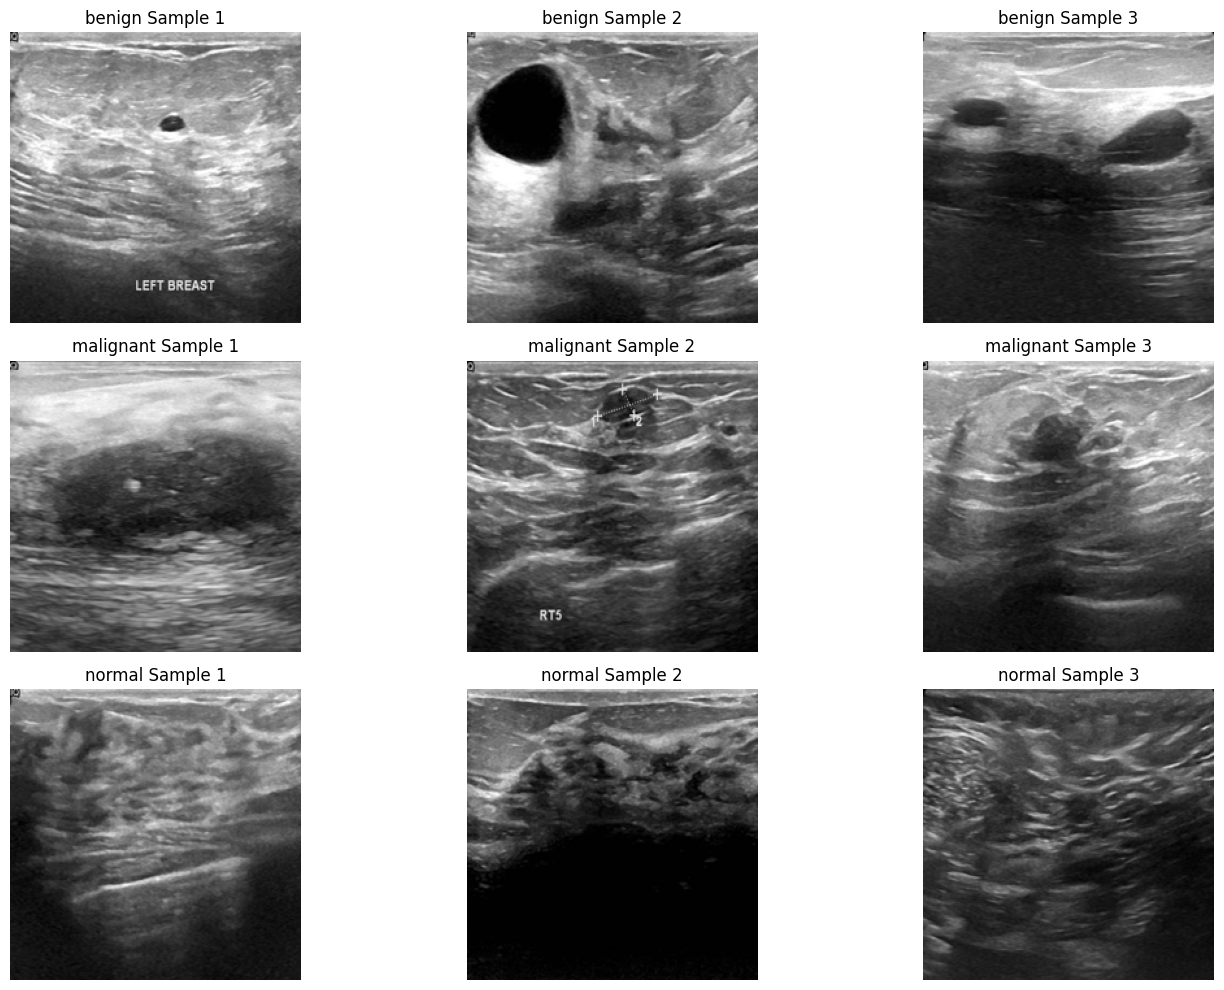

In [2]:
# Cell 2: Dataset Visualization
data_dir = "D:\\Dataset_BUSI_with_GT"
labels = ['benign', 'malignant', 'normal']

plt.figure(figsize=(15, 10))
for i, label in enumerate(labels):
    label_dir = os.path.join(data_dir, label)
    image_files = sorted([f for f in os.listdir(label_dir) 
                         if f.endswith('.png') and not f.endswith('_mask.png')])
    
    for j in range(3):
        img_path = os.path.join(label_dir, image_files[j])
        img = Image.open(img_path).resize((224, 224))
        
        plt.subplot(3, 3, i*3 + j + 1)
        plt.imshow(img)
        plt.title(f"{label} Sample {j+1}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# Cell 3: Dataset Preparation
def create_clean_dir(path):
    """Create directory, removing existing content if present"""
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

# Create base directory structure
base_dir = "D:\\BUSI_Classification"
create_clean_dir(base_dir)

# Create dataframe with image paths and labels
data = []
for label in labels:
    label_dir = os.path.join(data_dir, label)
    for img_file in os.listdir(label_dir):
        if img_file.endswith('.png') and '_mask' not in img_file:
            data.append({
                'path': os.path.join(label_dir, img_file),
                'label': label
            })

df = pd.DataFrame(data)

# Stratified split (70-15-15)
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.176, stratify=train_df['label'], random_state=42)  # 0.15/0.85 ≈ 0.176

# Copy images to structured directories
def copy_to_split(df, split_name):
    split_dir = os.path.join(base_dir, split_name)
    create_clean_dir(split_dir)
    for label in labels:
        create_clean_dir(os.path.join(split_dir, label))
        
    for _, row in df.iterrows():
        dest = os.path.join(split_dir, row['label'], os.path.basename(row['path']))
        shutil.copyfile(row['path'], dest)

copy_to_split(train_df, 'train')
copy_to_split(val_df, 'val')
copy_to_split(test_df, 'test')

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 546
Validation samples: 117
Test samples: 117


In [4]:
# Cell 4: Data Generators
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 546 images belonging to 3 classes.
Found 117 images belonging to 3 classes.
Found 117 images belonging to 3 classes.


In [5]:
# Cell 5: Model Architecture
def build_resnet():
    base_model = ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Freeze initial layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False
        
    # Unfreeze last 50 layers
    for layer in base_model.layers[-50:]:
        layer.trainable = True
    
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(3, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = build_resnet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,708,803 (166.74 MB)

 Trainable params: 18,001,155 (68.67 MB)

 Non-trainable params: 25,707,648 (98.07 MB)

In [6]:
# Cell 6: Training
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop],
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE
)

c:\Users\black\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4857 - loss: 1.1824
Epoch 1: val_accuracy improved from -inf to 0.72917, saving model to best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 133s 7s/step - accuracy: 0.4907 - loss: 1.1720 - val_accuracy: 0.7292 - val_loss: 0.5836
Epoch 2/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - accuracy: 0.7812 - loss: 0.6056

c:\Users\black\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.72917
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 763ms/step - accuracy: 0.7812 - loss: 0.6056 - val_accuracy: 0.7188 - val_loss: 0.6230
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6707 - loss: 0.6904
Epoch 3: val_accuracy improved from 0.72917 to 0.86458, saving model to best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 100s 6s/step - accuracy: 0.6725 - loss: 0.6879 - val_accuracy: 0.8646 - val_loss: 0.3879
Epoch 4/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:23 5s/step - accuracy: 0.6250 - loss: 0.8332
Epoch 4: val_accuracy did not improve from 0.86458
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 724ms/step - accuracy: 0.6250 - loss: 0.8332 - val_accuracy: 0.8542 - val_loss: 0.3951
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7602 - loss: 0.6062
Epoch 5: val_accuracy did not improve from 0.86458
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.7603 - loss: 0.6033 - val_accuracy: 0.8438 - val_loss: 0.3189
Epoch 6/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:20 5s/step - accuracy: 0.7812 - loss: 0.4041
Epoch 6: val_accuracy improved from 0.86458 to 0.87500, saving model to best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 804ms/step - accuracy: 0.7812 - loss: 0.4041 - val_accuracy: 0.8750 - val_loss: 0.3062
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7727 - loss: 0.5295
Epoch 7: val_accuracy did not improve from 0.87500
17/17 ━━━━━━━━━━━━━━━━━━━━ 105s 6s/step - accuracy: 0.7733 - loss: 0.5299 - val_accuracy: 0.8542 - val_loss: 0.4190
Epoch 8/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - accuracy: 0.8438 - loss: 0.3116
Epoch 8: val_accuracy did not improve from 0.87500
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 776ms/step - accuracy: 0.8438 - loss: 0.3116 - val_accuracy: 0.8646 - val_loss: 0.4255
Epoch 9/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8170 - loss: 0.4600
Epoch 9: val_accuracy did not improve from 0.87500
17/17 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - accuracy: 0.8173 - loss: 0.4585 - val_accuracy: 0.8229 - val_loss: 0.4963
Epoch 10/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:19 5s/step - accuracy: 0.7188 - loss: 0.6521
Epoch 10: val_accuracy did not improve fro

17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.8217 - loss: 0.3974 - val_accuracy: 0.8958 - val_loss: 0.4989
Epoch 12/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:22 5s/step - accuracy: 0.9062 - loss: 0.3009
Epoch 12: val_accuracy improved from 0.89583 to 0.90625, saving model to best_model.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 792ms/step - accuracy: 0.9062 - loss: 0.3009 - val_accuracy: 0.9062 - val_loss: 0.5011
Epoch 13/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8305 - loss: 0.4411
Epoch 13: val_accuracy did not improve from 0.90625
17/17 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - accuracy: 0.8315 - loss: 0.4391 - val_accuracy: 0.7604 - val_loss: 0.7626
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 6.


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8807 - loss: 0.3481

Test Accuracy: 0.8632
Test Loss: 0.4641

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step
Classification Report:
              precision    recall  f1-score   support

      benign       0.86      0.91      0.88        66
   malignant       0.87      0.87      0.87        31
      normal       0.88      0.70      0.78        20

    accuracy                           0.86       117
   macro avg       0.87      0.83      0.84       117
weighted avg       0.86      0.86      0.86       117



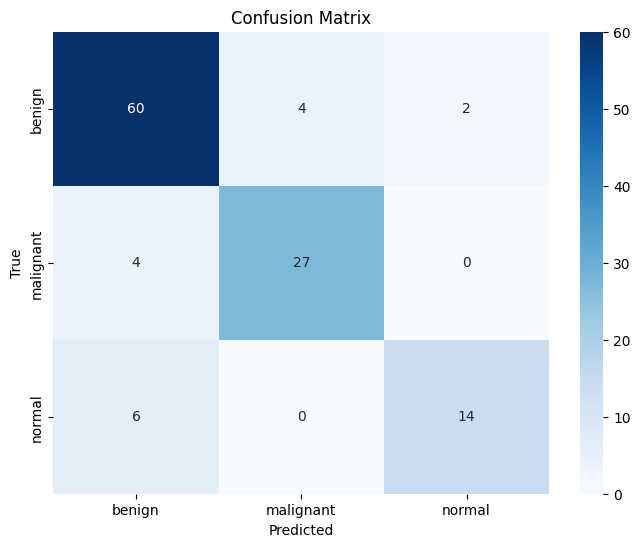

In [7]:
# Cell 7: Evaluation
model.load_weights('best_model.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}\n")

# Generate predictions
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.labels
class_names = list(test_gen.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

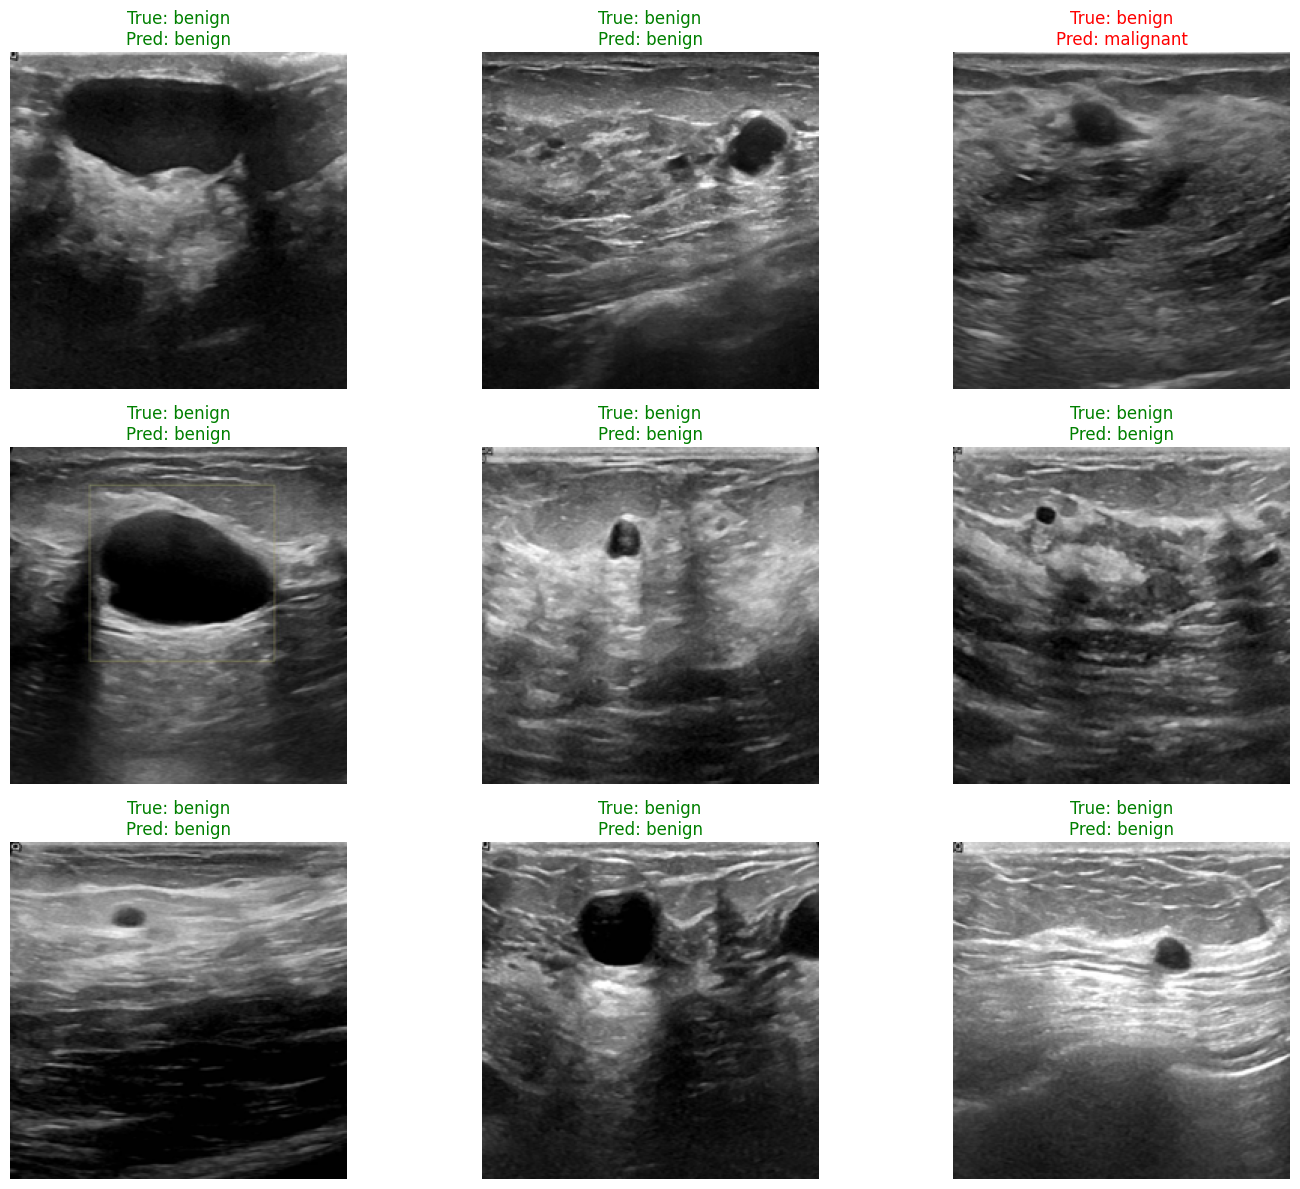

In [8]:
# Cell 8: Prediction Visualization
plt.figure(figsize=(15, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    img_path = os.path.join(test_gen.directory, test_gen.filenames[i])
    img = Image.open(img_path).resize((224, 224))
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='green' if true_label == pred_label else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()